[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [41]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [42]:
!nvidia-smi

Fri Jun  6 11:07:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             30W /   70W |     888MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [43]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [45]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [47]:
!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

--2025-06-06 11:13:03--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-06 11:13:04--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-06 11:13:04--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.c

## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

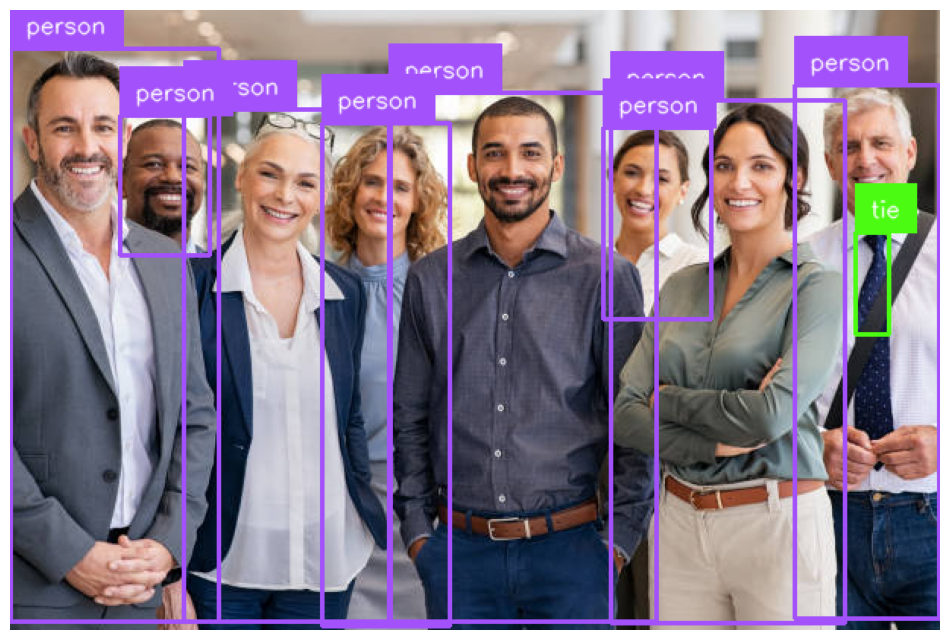

In [48]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [49]:
from roboflow import Roboflow
rf = Roboflow(api_key=os.environ["ROBOFLOW_API_KEY"])
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(27)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-Detection-27 in yolov12:: 100%|██████████| 390/390 [00:00<00:00, 5669.24it/s]


In [50]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [51]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [52]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['face']

roboflow:
  workspace: mohamed-traore-2ekkp
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [54]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.151 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/Face-Detection-27/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning /content/Face-Detection-27/train/labels.cache... 132 images, 9 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Face-Detection-27/valid/labels.cache... 38 images, 1 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.83G       3.08      4.281      4.291          9        640: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         38         49    0.00144      0.286     0.0011   0.000476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.12G      3.132        4.5      4.271          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         38         49    0.00144      0.286     0.0011   0.000476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.14G      2.957      4.238      4.234          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


                   all         38         49    0.00136      0.265     0.0011   0.000467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.11G      2.981       3.92       4.06         16        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]

                   all         38         49    0.00159      0.306    0.00215   0.000633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.14G      2.925      3.647      3.871         11        640: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         38         49    0.00149      0.286      0.003   0.000811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.97G      3.007      3.616       3.82          5        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.89it/s]

                   all         38         49    0.00147      0.286     0.0028   0.000802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.13G      2.844      3.282      3.533         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         38         49    0.00146      0.286    0.00337   0.000988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.97G      2.924      3.301      3.523         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         38         49    0.00149      0.286    0.00345   0.000949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.97G      2.619      2.919      3.271          6        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         38         49    0.00163      0.306    0.00298   0.000964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.13G      2.527      2.744      3.194          9        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         38         49    0.00163      0.306    0.00591    0.00153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      7.15G      2.475       2.63      3.206          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         38         49    0.00213      0.449      0.171      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.15G      2.453      2.467      3.119         12        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         38         49     0.0032      0.571    0.00634    0.00167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      7.11G      2.278      2.329      2.885         14        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         38         49     0.0441     0.0408     0.0291    0.00911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.14G       2.41      2.302      3.045          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         38         49      0.138      0.163     0.0535     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.15G      2.245      2.125      2.872          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         38         49     0.0984      0.245     0.0496     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.15G      2.275      2.019      2.891          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         38         49     0.0709      0.204     0.0379     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.11G      2.227      1.993        2.9          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         38         49      0.086      0.163     0.0724     0.0245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.14G      2.367      2.007      2.881         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         38         49      0.231      0.184      0.102     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.15G      2.168      1.876      2.815          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         38         49     0.0696      0.633     0.0769     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.15G       2.13      1.882      2.728          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         38         49      0.385      0.469        0.4      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.11G      2.186      1.716      2.734         16        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         38         49      0.523      0.531        0.5      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.14G        2.1      1.665      2.684         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         38         49      0.255      0.448      0.281      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.15G      2.092      1.729      2.749         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         38         49      0.679      0.648       0.58      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.15G      2.047      1.615      2.653         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         38         49        0.8      0.694      0.746      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.11G      2.025      1.506      2.613         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         38         49      0.767      0.714      0.739      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.14G      1.954      1.485      2.525          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         38         49      0.716      0.653      0.764      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.15G       1.89      1.392      2.482         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         38         49      0.655      0.816      0.784      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.15G      1.862      1.453      2.495          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         38         49      0.776      0.673       0.79      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.11G       1.94       1.47      2.601         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         38         49      0.778      0.653      0.782      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.14G      1.915      1.421      2.583          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         38         49      0.758      0.714      0.811      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      7.15G      1.944      1.428      2.564          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         38         49      0.734      0.676      0.763      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.15G      1.939      1.384      2.554          6        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         38         49      0.713      0.653      0.692      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.11G      1.841      1.348      2.443         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         38         49      0.786      0.898        0.9      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.14G      1.818      1.278      2.429         16        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         38         49      0.758      0.755      0.823      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.15G      1.731      1.295      2.359         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         38         49      0.947      0.776      0.898      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.15G      1.738      1.286      2.374         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         38         49      0.702      0.714      0.741      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.95G      1.753      1.317      2.437          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         38         49      0.862       0.49      0.655      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.98G      1.711      1.299      2.374         12        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         38         49      0.792      0.796      0.844       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      7.16G      1.645      1.332      2.319          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         38         49      0.888      0.878      0.924      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.15G      1.635      1.278      2.291          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         38         49      0.888      0.776       0.89      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.11G      1.612      1.236      2.268          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         38         49      0.881      0.776      0.902      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.99G      1.589      1.133      2.206         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         38         49      0.864      0.857      0.917       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.15G      1.594       1.17      2.246          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         38         49      0.975      0.791       0.89      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.16G      1.725      1.297      2.348         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         38         49      0.824      0.878      0.893      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.11G      1.517      1.146      2.149         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         38         49       0.93      0.776      0.894      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.14G      1.666      1.242      2.323          9        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         38         49      0.729      0.796      0.842      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.15G      1.593      1.182      2.192          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


                   all         38         49       0.83      0.797      0.844      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.15G      1.598      1.261      2.233         12        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         38         49      0.893      0.855      0.905      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.11G      1.531      1.109      2.146         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         38         49      0.874      0.852      0.916      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.14G       1.63      1.147      2.211          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         38         49      0.893      0.857      0.917      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.15G      1.558       1.18      2.171          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         38         49      0.783      0.812      0.865      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.16G       1.48      1.108      2.077          5        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         38         49      0.912      0.837      0.932      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.11G      1.578      1.125      2.167          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         38         49      0.953      0.837      0.942       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.99G       1.44       1.03      2.004         13        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         38         49      0.891      0.816      0.925      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.16G      1.478      1.054      2.122         12        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         38         49      0.874       0.85      0.913      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.16G      1.456      1.107      2.081         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         38         49      0.897      0.857      0.926      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.95G      1.404      1.098      2.045          5        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         38         49      0.935      0.959      0.958      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.15G      1.439       1.07       2.07          6        640: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         38         49      0.902      0.918      0.951      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.14G      1.325      1.018      1.958         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         38         49      0.914      0.866      0.961      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.14G      1.516      1.075      2.117         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         38         49      0.876      0.918      0.947      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.11G      1.414      1.056      1.978         15        640: 100%|██████████| 9/9 [00:04<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         38         49       0.95      0.898      0.949      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.14G      1.404     0.9923       2.04         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         38         49      0.976      0.835      0.943      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.15G      1.419      1.019      1.977          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         38         49      0.969      0.857      0.928      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.15G      1.432       1.01      2.035         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         38         49      0.933      0.847      0.946      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.11G      1.375      1.002      1.989          9        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         38         49      0.955      0.939      0.959      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.98G      1.432      1.006      2.006         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         38         49        0.9      0.922      0.942      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.15G      1.388      1.036      2.029         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         38         49      0.936      0.878      0.947      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.16G      1.351     0.9682      1.902         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         38         49      0.917      0.904      0.947      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.11G      1.394     0.9971      1.991         13        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         38         49      0.926      0.918      0.954      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.99G      1.367     0.9573      1.947         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         38         49      0.976      0.918      0.965      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.16G      1.357      1.024      1.937          9        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         38         49      0.915      0.898      0.935      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      7.16G      1.354     0.9449      1.914          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         38         49       0.94      0.918      0.967      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.11G      1.355     0.9677      1.897          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         38         49      0.954      0.851      0.957      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.14G      1.208     0.8787      1.839          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]

                   all         38         49      0.928      0.918      0.954       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.15G       1.43      1.018      1.984         10        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         38         49      0.937       0.91      0.952      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.16G      1.352     0.9553      1.913         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         38         49      0.953      0.836      0.963      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.12G      1.278     0.9985      1.872          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         38         49      0.954       0.85      0.956      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.16G      1.225     0.8857      1.861         10        640: 100%|██████████| 9/9 [00:04<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         38         49      0.937      0.907      0.955      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      7.15G       1.19     0.9374      1.772          4        640: 100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         38         49      0.912      0.918      0.933      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.15G      1.306     0.9429      1.878          9        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         38         49      0.958      0.928      0.959      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.95G      1.242     0.9176       1.86          8        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         38         49      0.945      0.918      0.932      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.16G       1.19     0.8459      1.778          9        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         38         49      0.942      0.918      0.974      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      7.14G      1.222      0.866      1.792         16        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         38         49      0.966      0.918      0.972      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.14G      1.204     0.8364      1.766          7        640: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         38         49      0.965      0.898      0.964      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.11G      1.257     0.9184       1.83         12        640: 100%|██████████| 9/9 [00:04<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         38         49      0.988      0.898      0.969      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.15G      1.256     0.8645      1.816         15        640: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         38         49      0.986      0.878      0.969      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.15G      1.271     0.9021      1.855         11        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         38         49      0.967      0.857      0.967       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.15G      1.247     0.9099      1.866          8        640: 100%|██████████| 9/9 [00:04<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all         38         49      0.938      0.921       0.97      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.11G      1.229     0.9093      1.836          4        640: 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         38         49      0.979      0.934      0.969       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      7.14G      1.263      0.929      1.875         11        640: 100%|██████████| 9/9 [00:04<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         38         49      0.971      0.939      0.973      0.695


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      7.15G       1.09     0.9366      1.759          6        640: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         38         49      0.968      0.939      0.981      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      7.16G      1.024     0.8507      1.661          5        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         38         49      0.916      0.939      0.976      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.11G      1.136      0.846      1.741          6        640: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         38         49      0.931      0.939      0.976       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.99G      1.031     0.7992      1.685          6        640: 100%|██████████| 9/9 [00:04<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         38         49      0.936      0.939      0.974      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      7.15G       1.06     0.8666      1.695          5        640: 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         38         49      0.918      0.916      0.971      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.16G      1.035     0.7889      1.688          7        640: 100%|██████████| 9/9 [00:04<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         38         49      0.937      0.916      0.969      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.11G      1.081     0.8368      1.763          3        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

                   all         38         49      0.919      0.926      0.969      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      7.14G      1.066     0.7822       1.72          5        640: 100%|██████████| 9/9 [00:04<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         38         49      0.939      0.936       0.97      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.15G      1.061     0.8236      1.704          6        640: 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         38         49      0.939      0.934       0.97      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      7.15G     0.9727     0.7455      1.626          4        640: 100%|██████████| 9/9 [00:04<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         38         49      0.928      0.939      0.972      0.712



100 epochs completed in 0.178 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 18.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,595 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


                   all         38         49      0.938       0.92      0.971      0.713
Speed: 0.2ms preprocess, 7.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train3


## Evaluate fine-tuned YOLOv12 model

In [58]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train3/

args.yaml					   train_batch0.jpg
confusion_matrix_normalized.png			   train_batch1.jpg
confusion_matrix.png				   train_batch2.jpg
events.out.tfevents.1749208524.cd26162bb49b.772.2  train_batch810.jpg
F1_curve.png					   train_batch811.jpg
labels_correlogram.jpg				   train_batch812.jpg
labels.jpg					   val_batch0_labels.jpg
P_curve.png					   val_batch0_pred.jpg
PR_curve.png					   val_batch1_labels.jpg
R_curve.png					   val_batch1_pred.jpg
results.csv					   weights
results.png


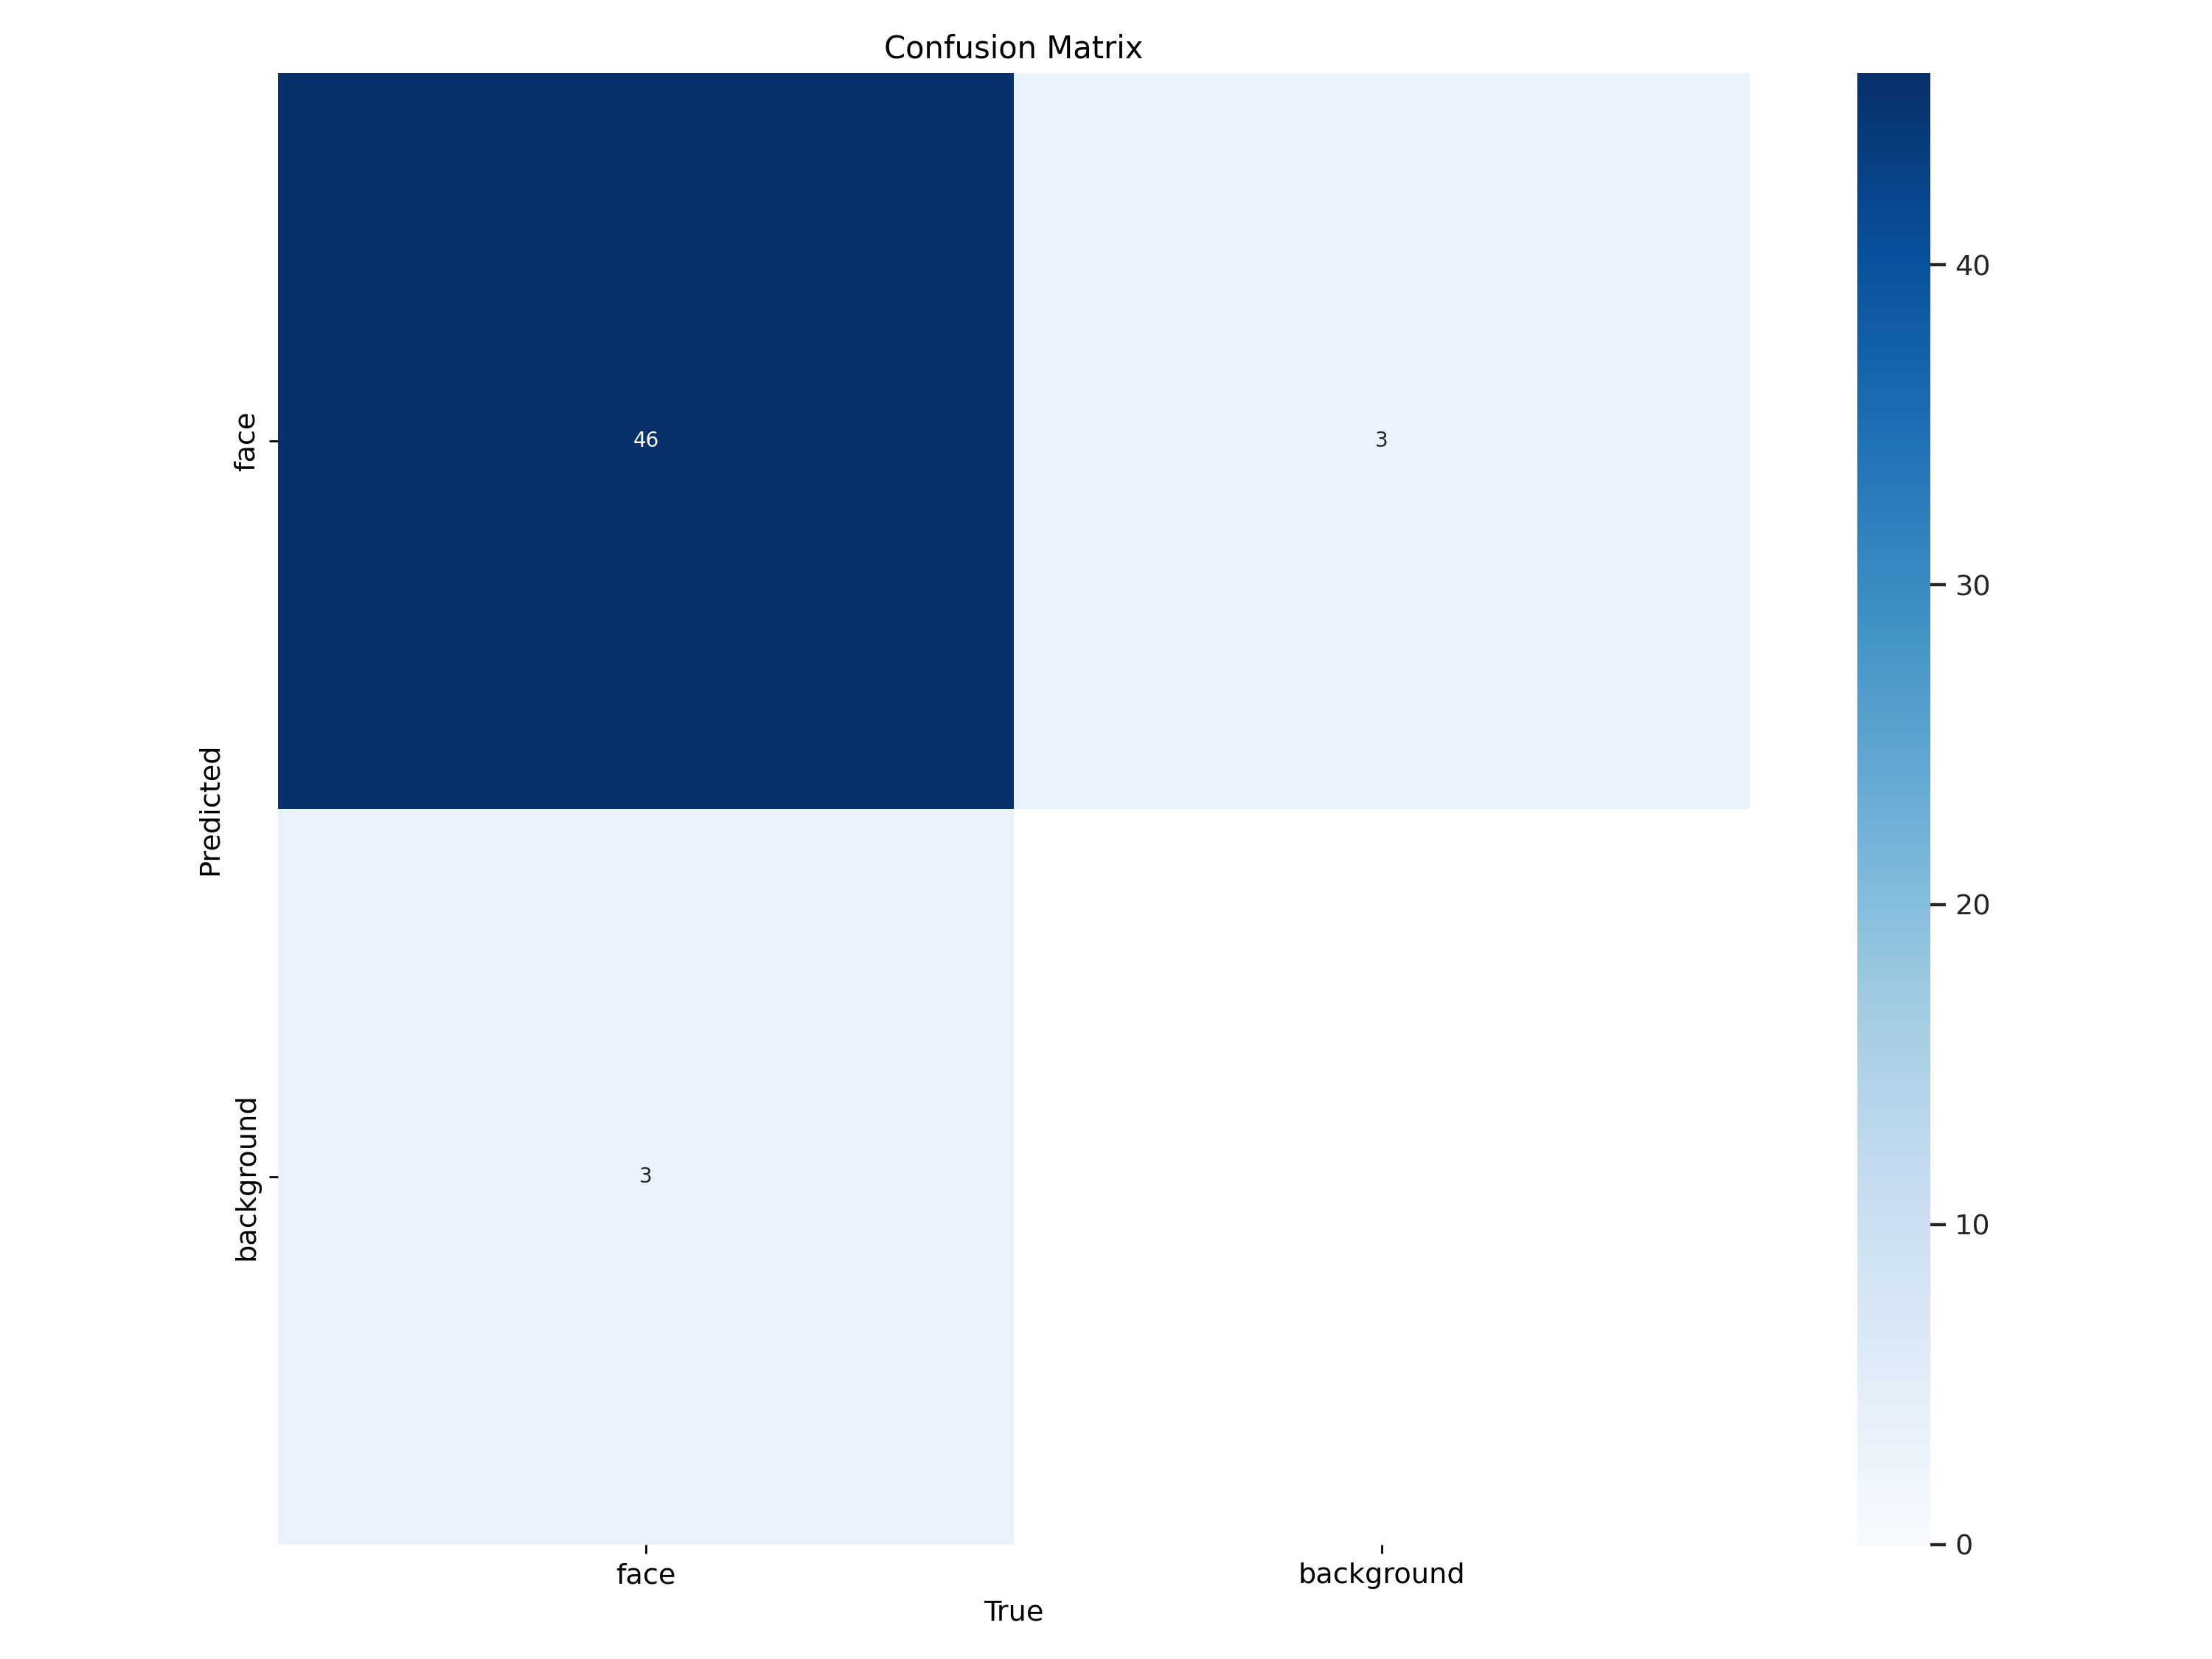

In [59]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix.png', width=1000)

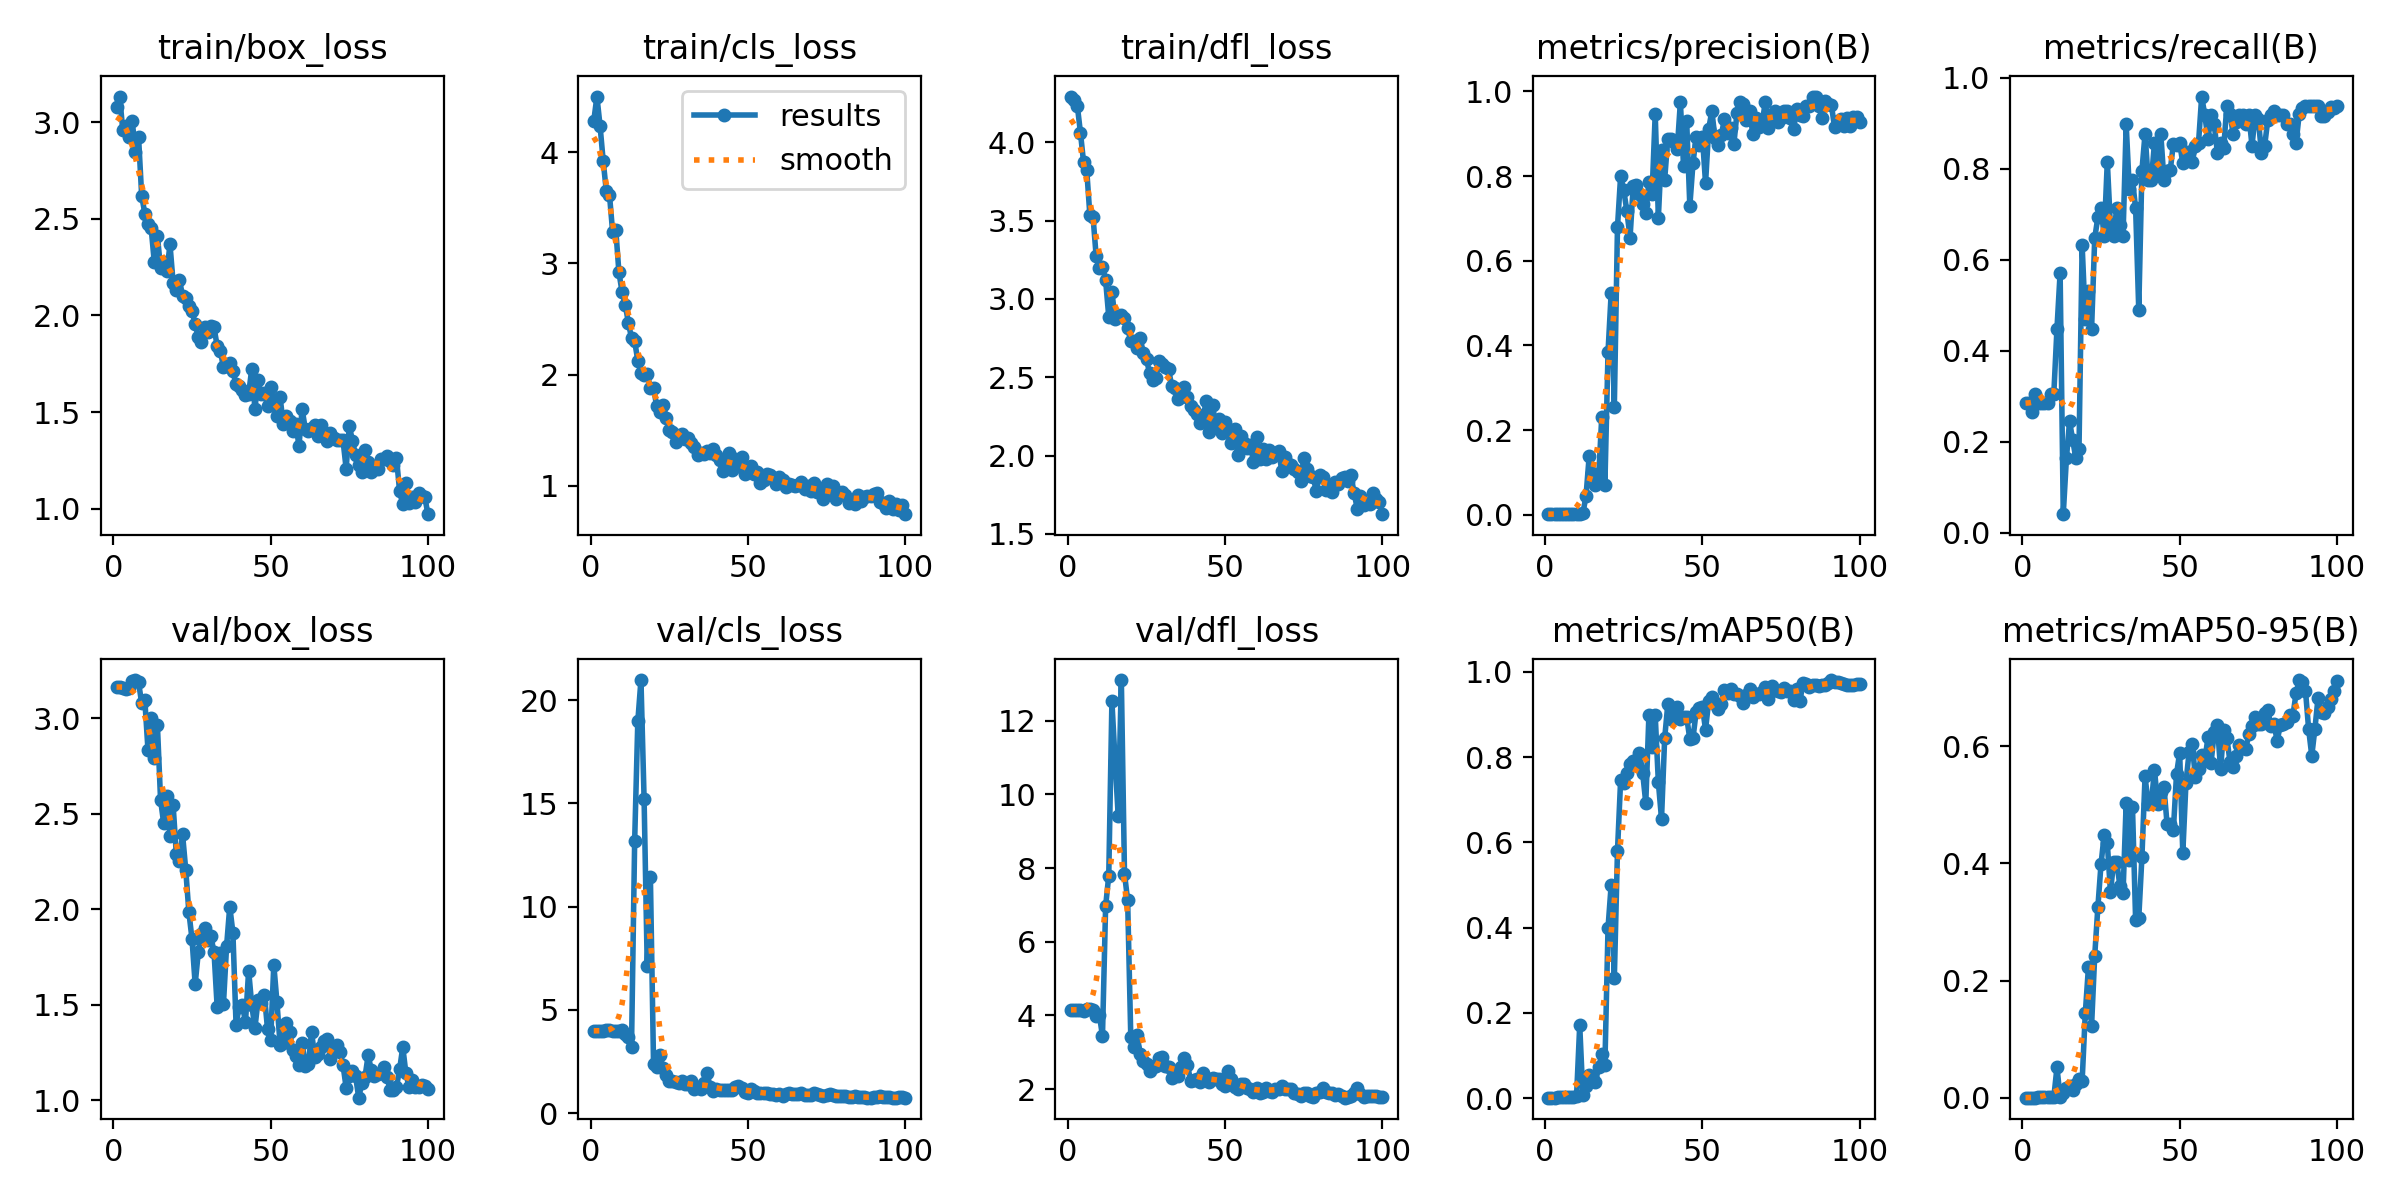

In [60]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train3/results.png', width=1000)

In [61]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['face']

In [62]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [63]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7105019097765932
mAP 50 0.9952424473216552
mAP 75 0.8485234828045115


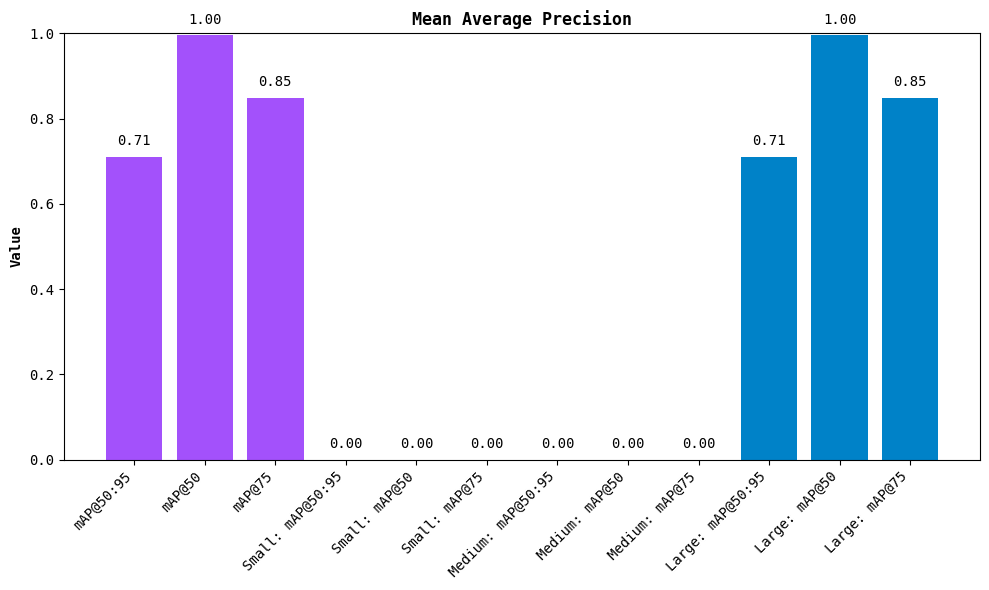

In [64]:
map.plot()

mAP 50:95 = 71.1 %
👉 Très bon score global. Ton modèle est performant même à des seuils de détection plus stricts (jusqu’à 0.95 d’IoU).

mAP 50 = 99.5 %
👉 Quasiment parfait ! À 50 % d'IoU, ton modèle détecte presque tous les objets correctement. Cela signifie que la localisation générale est impeccable.

mAP 75 = 84.9 %
👉 Très bonne précision même à un seuil élevé. Tes boîtes englobantes sont très bien alignées avec les objets réels.

En résumé :
✅ Détection fiable (presque aucun objet oublié)
✅ Localisation précise (les boîtes sont bien placées)
✅ Excellente qualité globale (mAP 50:95 > 70 % est très bon sur des datasets complexes)


## Run inference with fine-tuned YOLOv12 model

In [65]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

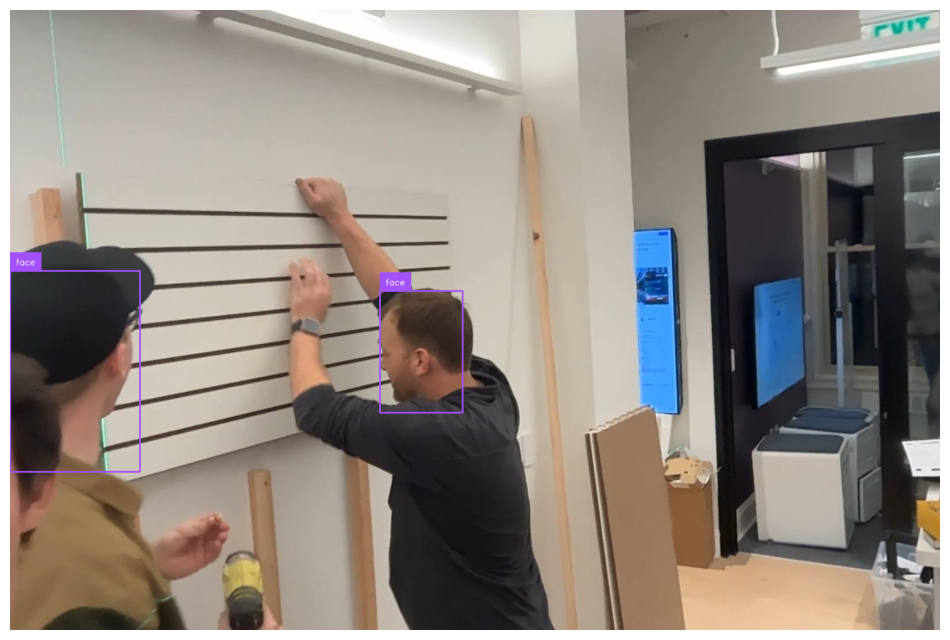

In [73]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

--2025-06-06 11:33:11--  https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg [following]
--2025-06-06 11:33:11--  https://github.com/laurent-pereira/ia-face-detector/raw/refs/heads/master/example.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg [following]
--2025-06-06 11:33:11--  https://raw.githubusercontent.com/laurent-pereira/ia-face-detector/refs/heads/master/example.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.c

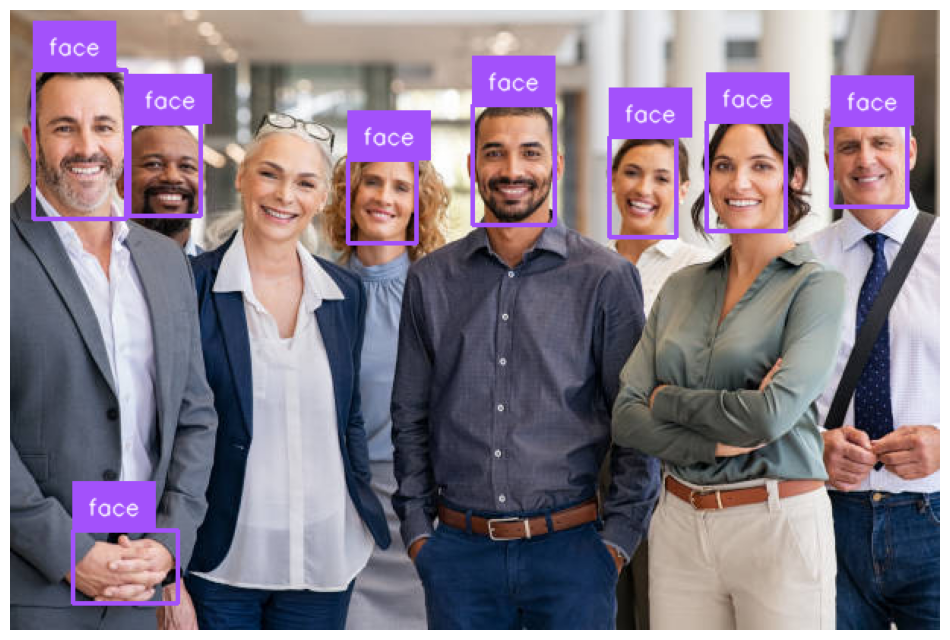

In [74]:
model = YOLO(f'/{HOME}/runs/detect/train3/weights/best.pt')

!wget https://github.com/laurent-pereira/ia-face-detector/blob/master/example.jpg?raw=true

image_path = f"{HOME}/example.jpg?raw=true"
image = cv2.imread(image_path)

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)